# Parameter Tuning with Hyperopt
This notebook will study using hyperopt and Bayesian optimization to do hyperparameter tuning.

## Data
The dataset will be Kaggle's board game geek dataset: https://www.kaggle.com/mrpantherson/board-game-data

We will build a model to predict if a board game receives an above-average rating.

In [22]:
import pandas as pd

# modeling algorithms
from catboost import CatBoostClassifier, Pool

# modeling helpers
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# configure visualization
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

# Get Data

In [2]:
# data path
datafile = '~/Documents/Python/data/bgg_db_1806.csv'

df = pd.read_csv(datafile)
print(f"N records: {len(df)}")
df.head()

N records: 4999


,rank,bgg_url,game_id,names,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,image_url,age,mechanic,owned,category,designer,weight
0,1,https://boardgamegeek.com/boardgame/174430/glo...,174430,Gloomhaven,1,4,120,60,120,2017,8.98893,8.61858,15376,https://cf.geekdo-images.com/original/img/lDN3...,12,"Action / Movement Programming, Co-operative Pl...",25928,"Adventure, Exploration, Fantasy, Fighting, Min...",Isaac Childres,3.7543
1,2,https://boardgamegeek.com/boardgame/161936/pan...,161936,Pandemic Legacy: Season 1,2,4,60,60,60,2015,8.66140,8.50163,26063,https://cf.geekdo-images.com/original/img/P_Sw...,13,"Action Point Allowance System, Co-operative Pl...",41605,"Environmental, Medical","Rob Daviau, Matt Leacock",2.8210
2,3,https://boardgamegeek.com/boardgame/182028/thr...,182028,Through the Ages: A New Story of Civilization,2,4,240,180,240,2015,8.60673,8.30183,12352,https://cf.geekdo-images.com/original/img/1d2h...,14,"Action Point Allowance System, Auction/Bidding...",15848,"Card Game, Civilization, Economic",Vlaada Chvátil,4.3678
3,4,https://boardgamegeek.com/boardgame/167791/ter...,167791,Terraforming Mars,1,5,120,120,120,2016,8.38461,8.19914,26004,https://cf.geekdo-images.com/original/img/o8z_...,12,"Card Drafting, Hand Management, Set Collection...",33340,"Economic, Environmental, Industry / Manufactur...",Jacob Fryxelius,3.2456
4,5,https://boardgamegeek.com/boardgame/12333/twil...,12333,Twilight Struggle,2,2,180,120,180,2005,8.33954,8.19787,31301,https://cf.geekdo-images.com/original/img/ZPnn...,13,"Area Control / Area Influence, Campaign / Batt...",42952,"Modern Warfare, Political, Wargame","Ananda Gupta, Jason Matthews",3.5518


In [3]:
# geek rating distribution
df.geek_rating.describe()

count    4999.000000
mean        6.088576
std         0.483212
min         5.640240
25%         5.726970
50%         5.905240
75%         6.303585
max         8.618580
Name: geek_rating, dtype: float64

In [4]:
df['aboveavg'] = (df.geek_rating > df.geek_rating.mean()).astype('int')
df.groupby('aboveavg')['geek_rating'].describe()

,count,mean,std,min,25%,50%,75%,max
aboveavg,,,,,,,,
0,3223.0,5.797524,0.125798,5.64024,5.686755,5.76681,5.889890,6.08855
1,1776.0,6.616764,0.442476,6.08879,6.263203,6.49368,6.882483,8.61858


In [5]:
df.aboveavg.value_counts(normalize=True)

0    0.644729
1    0.355271
Name: aboveavg, dtype: float64

## Data Prep

In [6]:
# keep top 5 values high-cardinality cols, set rest to "other"
top5category = list(df.category.value_counts()[:5].index)
df['cond_category'] = df.category.apply(lambda x: x if x in top5category else 'other')

top5mech = list(df.mechanic.value_counts()[:5].index)
df['cond_mechanic'] = df.mechanic.apply(lambda x: x if x in top5mech else 'other')

In [7]:
# shuffle dataset
df = df.sample(frac=1, replace=False, random_state=1118)

In [13]:
# set modeling target and features
idcol = 'game_id'
target = 'aboveavg'
features = ['min_players','max_players','avg_time','min_time','max_time','age','weight','cond_category','cond_mechanic']
df_model = df.set_index(idcol)
df_model.shape

(4999, 22)

In [14]:
# train/test split as 75%/25%
X_train, X_test, y_train, y_test = train_test_split(df_model[features], df_model[target]
                                                    ,test_size=0.25, random_state=42, stratify=df_model[target])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3749, 9) (1250, 9) (3749,) (1250,)


In [15]:
# features
cat_ftr = list(X_train.columns[X_train.dtypes=='O'])
print(f"Categorical features: {cat_ftr}")

cont_ftr = list(X_train.select_dtypes(include=['int','float']).columns)
print(f"Continuous features: {cont_ftr}")

Categorical features: ['cond_category', 'cond_mechanic']
Continuous features: ['min_players', 'max_players', 'avg_time', 'min_time', 'max_time', 'age', 'weight']


# Catboost Model

In [30]:
def modelfit(model, X_train, y_train, modelname):

    #train model
    model.fit(X_train, y_train)

    # predict probabilities
    predprob = model.predict_proba(X_train)[:,1]

    # training AUC
    auc = roc_auc_score(y_train, predprob)
    print(f"Training set AUC: {auc:0.5}")

    # feature importance
    feat_imp = pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)
    feat_imp.iloc[0:50][::-1].plot(kind='barh'
                                    ,title=f'Feature Importance: {modelname}'
                                    ,figsize = (10,8))
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

    return auc


In [31]:
# dict for results
rslt_dict = {}

In [32]:
model_cat = CatBoostClassifier(iterations=1000, learning_rate = 0.01, cat_features=cat_ftr, verbose=False)

## Before Tuning

Training set AUC: 0.75254


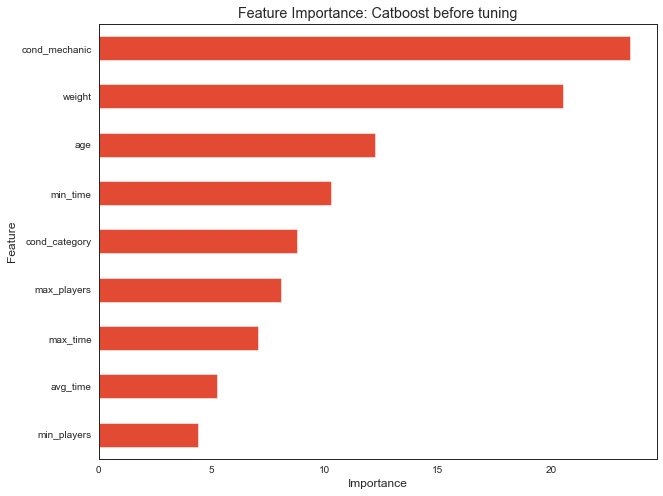

In [33]:
model_name = 'Catboost before tuning'
cb_notune_auc = modelfit(model_cat, X_train, y_train, modelname=model_name)
rslt_dict[model_name] = cb_notune_auc

## Evaluate on Test Set